# 安徽安庆市项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Integrated Source Apportionment Method`*

---
*@author: Evan*\
*@date: 2023-05-09*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
import ModelEvaLib as me

## 读取数据

In [2]:
isam = xr.open_dataset('F:/Data/case_anqing/April/April_ISAM1.nc')
isam

<xarray.Dataset>
Dimensions:    (time: 720, level: 26, y: 138, x: 135)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-01 ... 2023-04-30T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 703.9 659.0 616.2
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    O3_AQ      (time, level, y, x) float32 ...
    O3_HF      (time, level, y, x) float32 ...
    O3_TL      (time, level, y, x) float32 ...
    O3_CZ      (time, level, y, x) float32 ...
    O3_JJ      (time, level, y, x) float32 ...
    O3_OTH     (time, level, y, x) float32 ...
    O3_ICO     (time, level, y, x) float32 ...
    O3_BCO     (time, level, y, x) float32 ...
Attributes:
    case:     Anqing_202304
    grid:     CN3AH_135X138

In [3]:
# 计算L1和L2两层平均数据
# 获取需要遍历的变量列表和相应的变量名称列表
var_list = [isam.O3_AQ, isam.O3_HF, isam.O3_TL, isam.O3_CZ, 
            isam.O3_JJ, isam.O3_OTH, isam.O3_ICO, isam.O3_BCO]
name_list = ['AQ', 'HF', 'TL', 'CZ', 'JJ', 'OTH', 'ICO', 'BCO']

# 初始化 L1 和 L2 变量字典
L1_dict = {}
L2_dict = {}

for i, var in enumerate(var_list):
    # 在 L1 字典中存储 L1 变量
    L1_dict[f"{name_list[i]}_L1"] = np.mean(var[:,:4,:,:], axis=1)
    
    # 在 L2 字典中存储 L2 变量
    L2_dict[f"{name_list[i]}_L2"] = np.mean(var[:,4:19,:,:], axis=1)

# 解包 L1 和 L2 字典，将变量重新赋值给原始变量名称
AQ_L1, HF_L1, TL_L1, CZ_L1, JJ_L1, OTH_L1, ICO_L1, BCO_L1 = L1_dict.values()
AQ_L2, HF_L2, TL_L2, CZ_L2, JJ_L2, OTH_L2, ICO_L2, BCO_L2 = L2_dict.values()

In [13]:
# 计算区域范围内的平均值
import geopandas as gpd

shpurban = 'F:/Data/case_anqing/shapefile/Anqing_urban/urban.shp'
shp = gpd.read_file(shpurban)

# 获取需要遍历的变量列表
var_list = [AQ_L1, HF_L1, TL_L1, CZ_L1, JJ_L1, OTH_L1, ICO_L1, BCO_L1, 
            AQ_L2, HF_L2, TL_L2, CZ_L2, JJ_L2, OTH_L2, ICO_L2, BCO_L2]

for i in range(np.size(isam.latitude,0)):
    for j in range(np.size(isam.latitude,1)):
        if me.polygon_to_mask(shp.geometry[0],isam.longitude[i,j],isam.latitude[i,j])==False:
            # 将所有需要置为 nan 的变量放到一个列表中，以便循环处理
            nan_var_list = [var[:,i,j] for var in var_list]
            
            # 循环将每个变量置为 nan
            for nan_var in nan_var_list:
                nan_var[:] = np.nan

calc_var_list = ['aq_L1', 'hf_L1', 'tl_L1', 'cz_L1', 'jj_L1', 'oth_L1', 'ico_L1', 'bco_L1',
                 'aq_L2', 'hf_L2', 'tl_L2', 'cz_L2', 'jj_L2', 'oth_L2', 'ico_L2', 'bco_L2']

for i, var in enumerate(var_list):
    # 计算变量的均值
    var_mean = np.nanmean(np.nanmean(var,1),1)
    
    # 将变量均值赋值回原始变量
    exec(f"{calc_var_list[i]} = var_mean")

aq_L1.shape

(720,)

In [14]:
all_L1 = aq_L1+hf_L1+tl_L1+cz_L1+jj_L1+oth_L1+ico_L1+bco_L1
all_L2 = aq_L2+hf_L2+tl_L2+cz_L2+jj_L2+oth_L2+ico_L2+bco_L2

# 设定变量名称循环列表
names = ['aq', 'hf', 'tl', 'cz', 'jj', 'oth', 'ico', 'bco']

# 计算ratio
ratio_L1 = {}
ratio_L2 = {}
for name in names:
    var_L1 = f"{name}_L1"
    var_L2 = f"{name}_L2"
    ratio_L1[f"{var_L1}_rt"] = globals()[var_L1] / all_L1
    ratio_L2[f"{var_L2}_rt"] = globals()[var_L2] / all_L2
    
aq_L1_rt, hf_L1_rt, tl_L1_rt, cz_L1_rt, jj_L1_rt, oth_L1_rt, ico_L1_rt, bco_L1_rt = ratio_L1.values()
aq_L2_rt, hf_L2_rt, tl_L2_rt, cz_L2_rt, jj_L2_rt, oth_L2_rt, ico_L2_rt, bco_L2_rt = ratio_L2.values()

## 画图1：柱状图/时间序列图

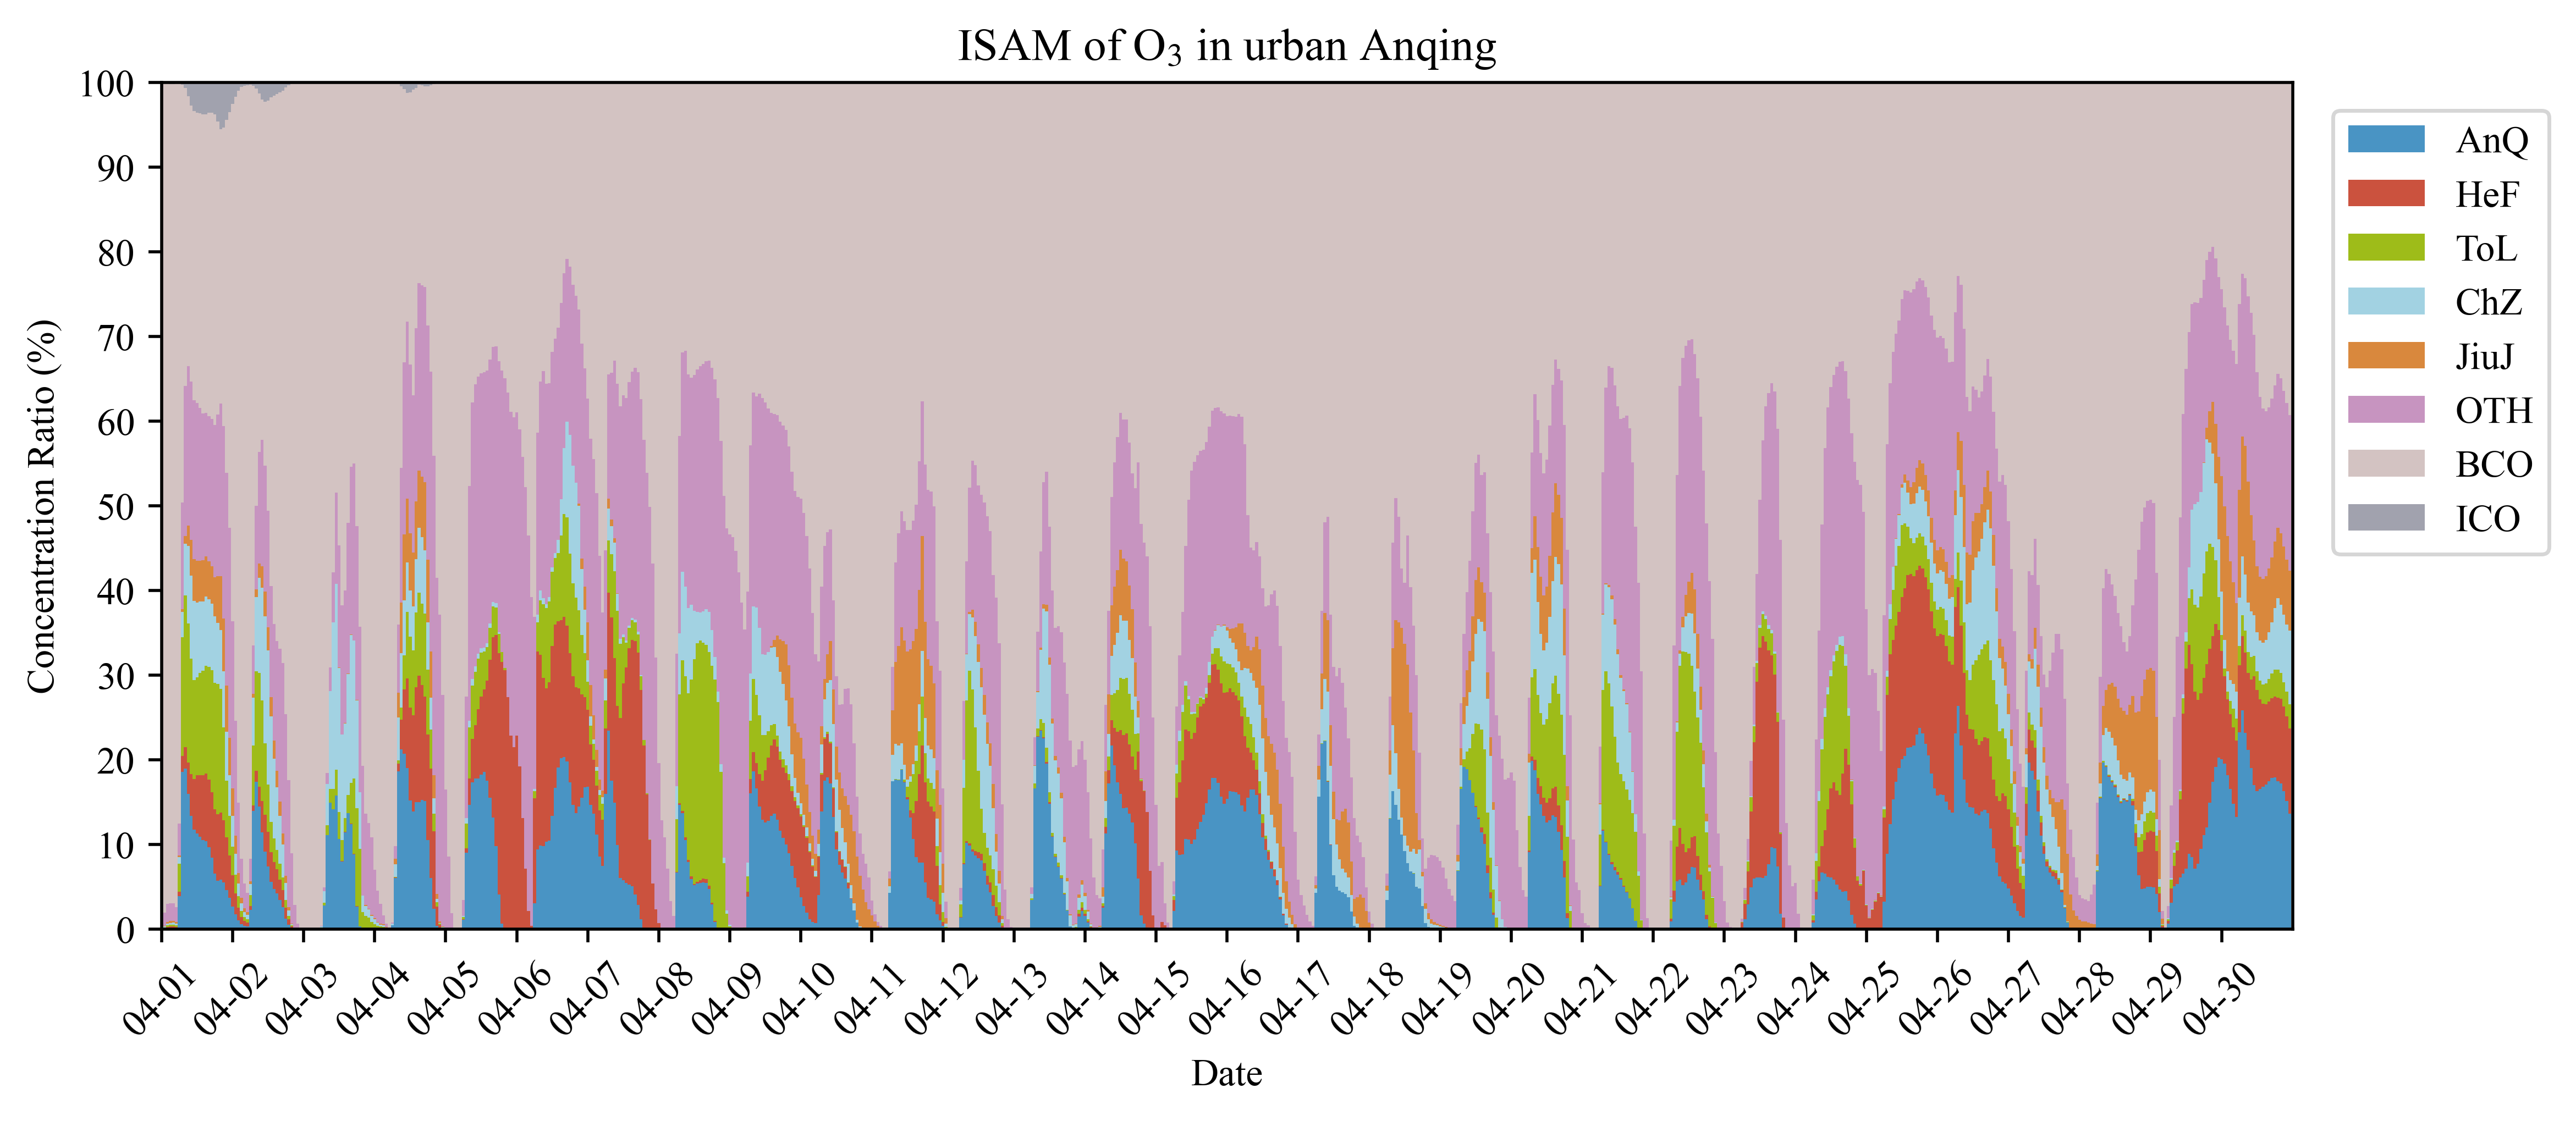

In [35]:
ts=np.arange(0,720)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,aq_L1_rt,color=coloraq,width=1)
b2=ax.bar(ts,hf_L1_rt,bottom=aq_L1_rt,color=colorhf,width=1)
b3=ax.bar(ts,tl_L1_rt,bottom=hf_L1_rt+aq_L1_rt,color=colortl,width=1)
b4=ax.bar(ts,cz_L1_rt,bottom=tl_L1_rt+hf_L1_rt+aq_L1_rt,color=colorcz,width=1)
b5=ax.bar(ts,jj_L1_rt,bottom=cz_L1_rt+tl_L1_rt+hf_L1_rt+aq_L1_rt,color=colorjj,width=1)
b6=ax.bar(ts,oth_L1_rt,bottom=jj_L1_rt+cz_L1_rt+tl_L1_rt+hf_L1_rt+aq_L1_rt,color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,bco_L1_rt,bottom=oth_L1_rt+jj_L1_rt+cz_L1_rt+tl_L1_rt+hf_L1_rt+aq_L1_rt,color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,ico_L1_rt,bottom=bco_L1_rt+oth_L1_rt+jj_L1_rt+cz_L1_rt+tl_L1_rt+hf_L1_rt+aq_L1_rt,color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('ISAM of O$_3$ in urban Anqing')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration Ratio (%)')
ax.set_xticks(np.arange(0,720,24))
ax.set_xticklabels(pd.date_range('2023-04-01','2023-04-30',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,1)
ax.set_xlim(0,720)

plt.show()

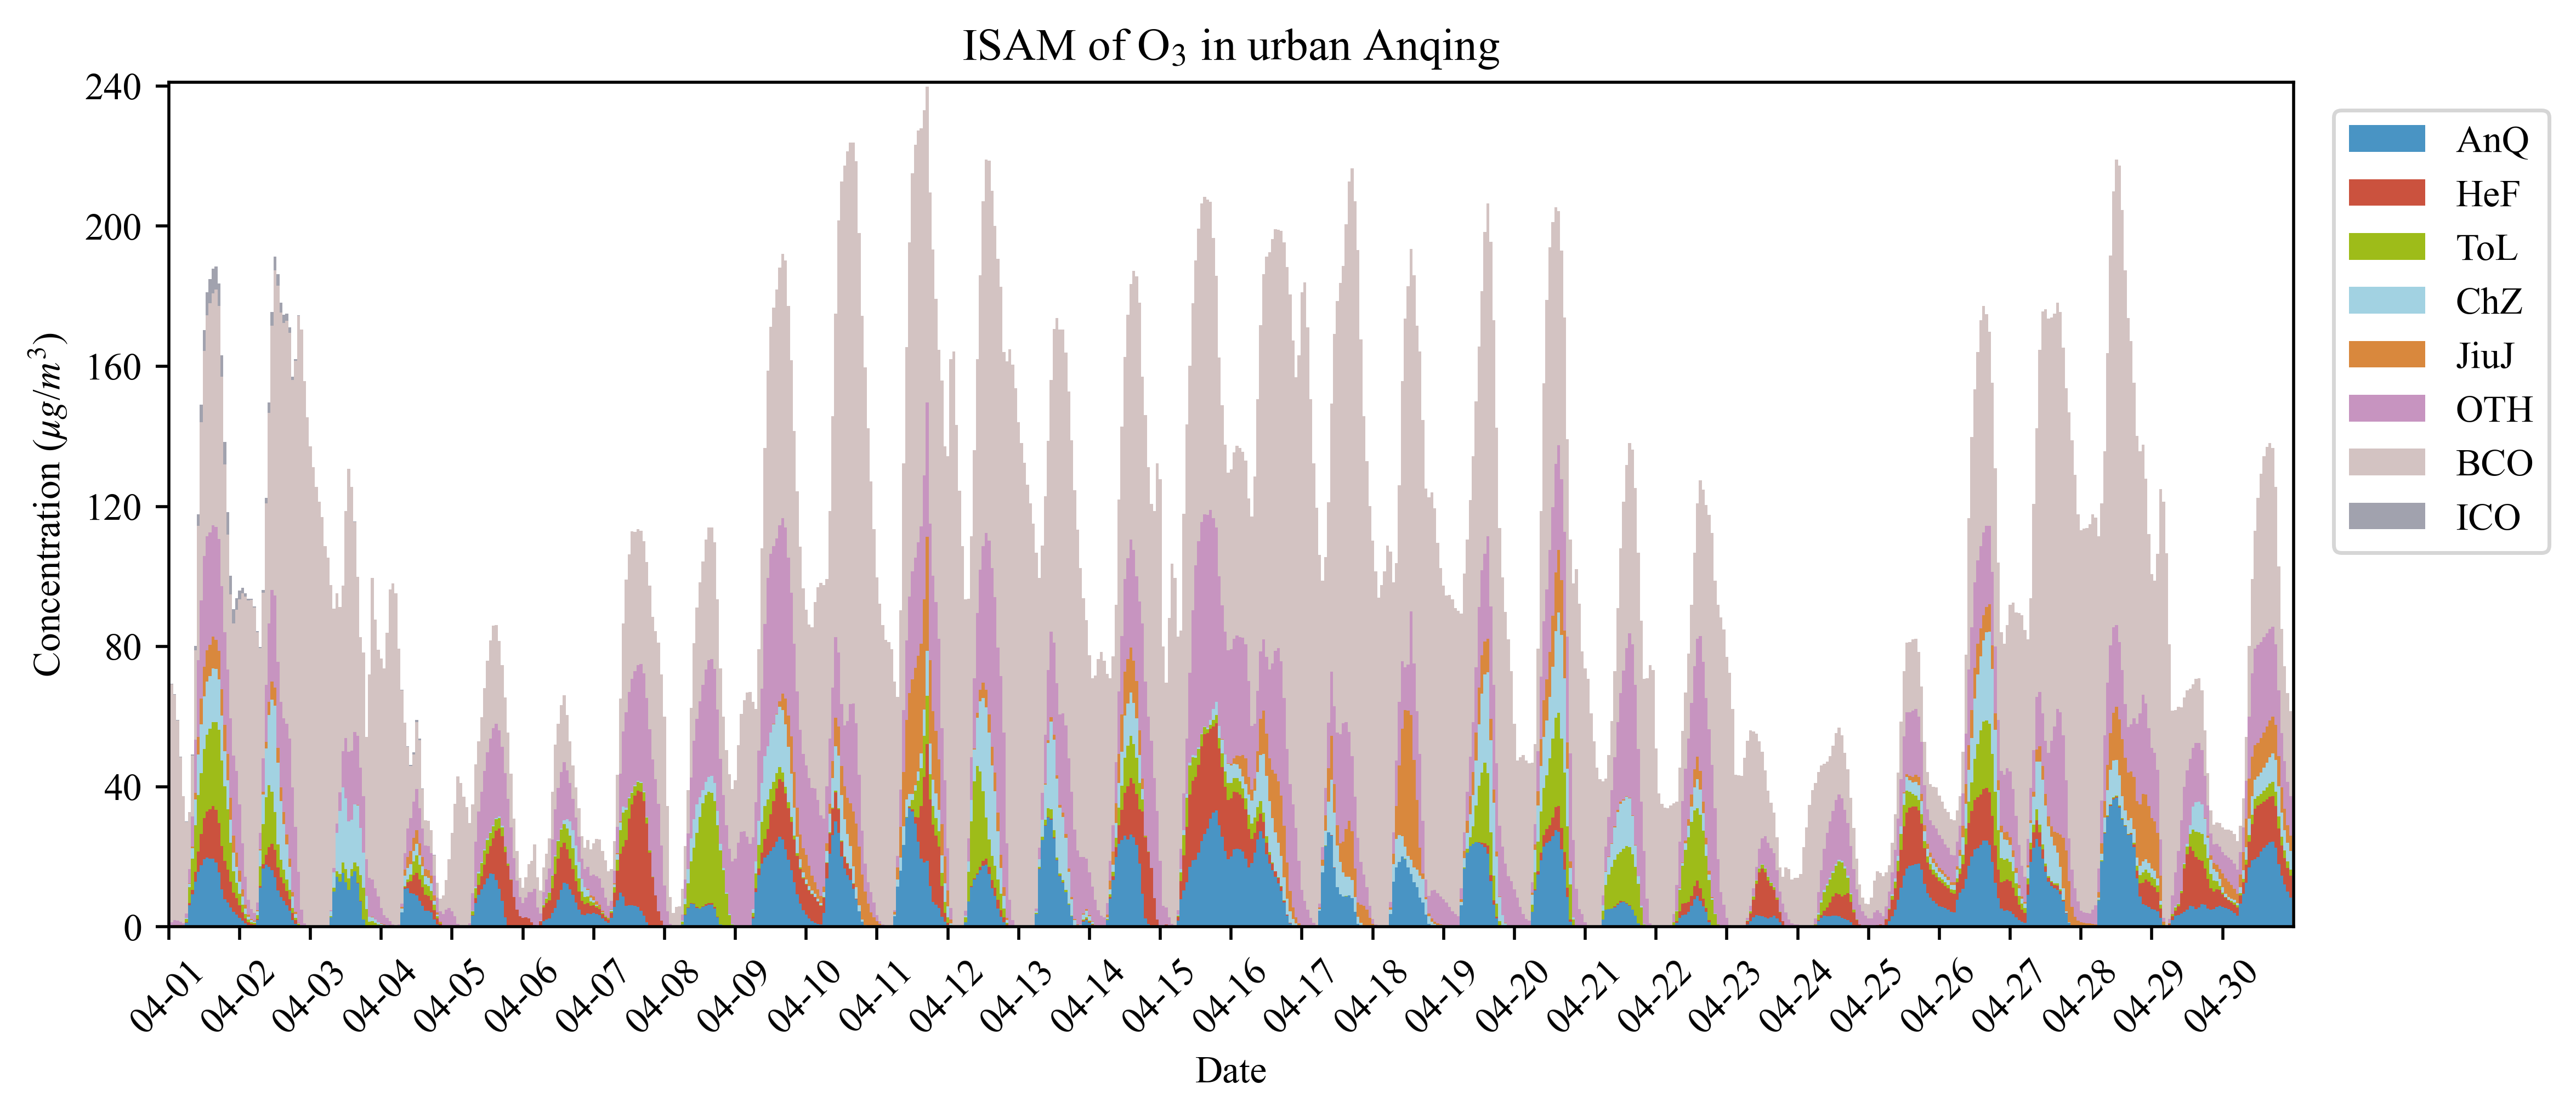

In [43]:
ts=np.arange(0,720)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,aq_L1,color=coloraq,width=1)
b2=ax.bar(ts,hf_L1,bottom=aq_L1,color=colorhf,width=1)
b3=ax.bar(ts,tl_L1,bottom=hf_L1+aq_L1,color=colortl,width=1)
b4=ax.bar(ts,cz_L1,bottom=tl_L1+hf_L1+aq_L1,color=colorcz,width=1)
b5=ax.bar(ts,jj_L1,bottom=cz_L1+tl_L1+hf_L1+aq_L1,color=colorjj,width=1)
b6=ax.bar(ts,oth_L1,bottom=jj_L1+cz_L1+tl_L1+hf_L1+aq_L1,color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,bco_L1,bottom=oth_L1+jj_L1+cz_L1+tl_L1+hf_L1+aq_L1,color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,ico_L1,bottom=bco_L1+oth_L1+jj_L1+cz_L1+tl_L1+hf_L1+aq_L1,color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('ISAM of O$_3$ in urban Anqing')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(np.arange(0,720,24))
ax.set_xticklabels(pd.date_range('2023-04-01','2023-04-30',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,241,40))
# ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,241)
ax.set_xlim(0,720)

plt.show()

In [42]:
print('REGION', 'MEAN', 'MIN', 'MAX')
print('Anqing',np.mean(aq_L1_rt).round(2),np.min(aq_L1_rt).round(2),np.max(aq_L1_rt).round(2))
print('Anqing',np.mean(aq_L1).round(2),np.min(aq_L1).round(2),np.max(aq_L1).round(2))

print('Hefei',np.mean(hf_L1_rt).round(2),np.min(hf_L1_rt).round(2),np.max(hf_L1_rt).round(2))
print('Hefei',np.mean(hf_L1).round(2),np.min(hf_L1).round(2),np.max(hf_L1).round(2))

print('Tongl',np.mean(tl_L1_rt).round(2),np.min(tl_L1_rt).round(2),np.max(tl_L1_rt).round(2))
print('Tongl',np.mean(tl_L1).round(2),np.min(tl_L1).round(2),np.max(tl_L1).round(2))

print('Chizh',np.mean(cz_L1_rt).round(2),np.min(cz_L1_rt).round(2),np.max(cz_L1_rt).round(2))
print('Chizh',np.mean(cz_L1).round(2),np.min(cz_L1).round(2),np.max(cz_L1).round(2))

print('Jiuji',np.mean(jj_L1_rt).round(2),np.min(jj_L1_rt).round(2),np.max(jj_L1_rt).round(2))
print('Jiuji',np.mean(jj_L1).round(2),np.min(jj_L1).round(2),np.max(jj_L1).round(2))

print('OTHER',np.mean(oth_L1_rt).round(2),np.min(oth_L1_rt).round(2),np.max(oth_L1_rt).round(2))
print('OTHER',np.mean(oth_L1).round(2),np.min(oth_L1).round(2),np.max(oth_L1).round(2))

print('BCON',np.mean(bco_L1_rt).round(2),np.min(bco_L1_rt).round(2),np.max(bco_L1_rt).round(2))
print('BCON',np.mean(bco_L1).round(2),np.min(bco_L1).round(2),np.max(bco_L1).round(2))

print('ICON',np.mean(ico_L1_rt).round(2),np.min(ico_L1_rt).round(2),np.max(ico_L1_rt).round(2))
print('ICON',np.mean(ico_L1).round(2),np.min(ico_L1).round(2),np.max(ico_L1).round(2))

REGION MEAN MIN MAX
Anqing 0.07 0.0 0.26
Anqing 7.91 0.0 36.81
Hefei 0.05 0.0 0.31
Hefei 4.41 0.0 33.85
Tongl 0.04 0.0 0.28
Tongl 3.78 0.0 31.78
Chizh 0.04 0.0 0.22
Chizh 4.53 0.0 31.44
Jiuji 0.03 0.0 0.23
Jiuji 3.44 0.0 41.43
OTHER 0.17 0.0 0.47
OTHER 16.33 0.0 60.77
BCON 0.6 0.19 1.0
BCON 62.52 3.33 176.44
ICON 0.0 0.0 0.05
ICON 0.16 0.0 7.08
